# Desafio 2
## Koller Tomas

## Consigna:

* Crear sus propios vectores con Gensim basado en lo visto en clase con otro artista del dataset Songs
* Elegir terminos de interes y buscar terminos mas similares y menos similares
* Realizar una reduccion de dimensionalidad de embeddings, llevandolos a 2 dimensiones. Graficar los embeddings proyectados y seleccionar una cantidad de terminos (variable MAX_WORDS) de forma tal que la visualizacion sea adecuada.
* Inpeccionar el grafico y buscar pequeños grupos de palabras que puedan formarse. Interpretarlos e intentar obtener conclusiones. En lo posible, acompañar los grupos de palabras con capturas (y pegarlas en celdas de texto)

---

Se Realizan los imports necesarios

In [1]:
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models.callbacks import CallbackAny2Vec
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing


2025-11-11 13:36:06.711559: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-11 13:36:06.713302: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 13:36:07.062656: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-11 13:36:11.722874: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Se descarga el dataset provisto por la catedra 

In [2]:
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


Para realizar este desafío se van a utilizar las letras de las canciones de Bob Marley. No soy un conocedor profundo de sus canciones, pero sí de las temáticas que las caracterizan. Por eso, el análisis de la cercanía entre palabras se realizará desde una perspectiva semántica y temática, priorizando el sentido general de los conceptos por encima de su aparición en canciones específicas.

In [3]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/blink-182.txt', sep='/n', header=None)
df.head()

/tmp/ipykernel_12089/1673936908.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/blink-182.txt', sep='/n', header=None)


,0
0,Can we forget about the things I said when I w...
1,I didn't mean to call you that
2,I can't remember what was said
3,Or what you threw at me Please tell me
4,Please tell me why


In [4]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 2332


Se tokenizan los documentos

In [5]:
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

sentence_tokens[:2]

[['can',
  'we',
  'forget',
  'about',
  'the',
  'things',
  'i',
  'said',
  'when',
  'i',
  'was',
  'drunk'],
 ['i', "didn't", 'mean', 'to', 'call', 'you', 'that']]

In [6]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

Se crea el modelo

In [7]:
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [8]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [9]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 2332


In [10]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 567


Se entrena el modelo

In [11]:
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 170530.1875
Loss after epoch 1: 101133.90625
Loss after epoch 2: 99647.5
Loss after epoch 3: 98516.84375
Loss after epoch 4: 98609.25
Loss after epoch 5: 100528.3125
Loss after epoch 6: 98984.125
Loss after epoch 7: 95620.875
Loss after epoch 8: 94330.875
Loss after epoch 9: 90458.1875
Loss after epoch 10: 79372.5625
Loss after epoch 11: 77926.75
Loss after epoch 12: 76031.0
Loss after epoch 13: 74663.5
Loss after epoch 14: 74584.0
Loss after epoch 15: 72986.125
Loss after epoch 16: 73307.75
Loss after epoch 17: 71882.75
Loss after epoch 18: 71969.125
Loss after epoch 19: 72088.625


(228452, 395020)

In [12]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["love"], topn=10)

[('falls', 0.8595882654190063),
 ('deep', 0.8320145606994629),
 ('sneak', 0.8170187473297119),
 ('rain', 0.8168491125106812),
 ('fell', 0.8153220415115356),
 ('world', 0.804535984992981),
 ('guy', 0.8038867712020874),
 ('bed', 0.7992546558380127),
 ('smoke', 0.797231912612915),
 ('those', 0.7894316911697388)]

In [14]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["rock"], topn=10)

[('at', 0.9271374344825745),
 ('show', 0.9209043979644775),
 ('punk', 0.9124482870101929),
 ('deep', 0.8699405193328857),
 ('planet', 0.8374500274658203),
 ('girl', 0.8270200490951538),
 ('bed', 0.825936496257782),
 ('those', 0.8196133375167847),
 ('world', 0.809995174407959),
 ('rain', 0.8088849186897278)]

In [16]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["always"], topn=10)

[('wanting', 0.8919386267662048),
 ('hearing', 0.8305486440658569),
 ('sick', 0.8183984756469727),
 ('nervous', 0.8155031800270081),
 ('words', 0.7688414454460144),
 ('cool', 0.7676026821136475),
 ('of', 0.7623150944709778),
 ('around', 0.7605947852134705),
 ('yourself', 0.7578710317611694),
 ('hanging', 0.7539508938789368)]

In [17]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["life"], topn=10)

[('school', 0.8549939393997192),
 ('car', 0.8400205969810486),
 ('made', 0.8310319781303406),
 ('very', 0.8164418935775757),
 ('front', 0.8158531785011292),
 ('favorite', 0.8149373531341553),
 ('fucked', 0.8123654723167419),
 ('yard', 0.8038392066955566),
 ('while', 0.8001101613044739),
 ('loud', 0.7945459485054016)]

In [18]:
# el método `get_vector` permite obtener los vectores:
vector_life = w2v_model.wv.get_vector("life")
print(vector_life)

[-3.74947768e-03  1.00658663e-01  2.30336022e-02 -1.32127702e-01
  1.96124464e-02 -1.55764580e-01  5.69821894e-02  1.82765350e-01
 -8.88500921e-03 -8.91962275e-02  1.28559649e-01  3.59533057e-02
 -1.25427470e-01  9.18460339e-02  7.15190470e-02 -1.05048075e-01
 -2.50155702e-02 -3.77510674e-02  4.51493561e-02  1.01394355e-01
 -1.32781360e-02 -2.42071063e-03  7.78443441e-02 -1.51973963e-01
 -3.04034241e-02 -7.56621882e-02 -2.00154752e-01 -1.94477197e-03
  1.55046761e-01 -2.23469675e-01 -1.24250740e-01 -9.98951122e-02
  9.80331972e-02  1.69350609e-01 -8.66152868e-02  7.96060935e-02
 -1.91011056e-01  3.60548752e-03 -2.15610668e-01  1.42895663e-02
  2.63230540e-02 -8.03640038e-02  7.81967491e-02 -4.17306609e-02
 -7.09063858e-02  5.61849698e-02  1.48620337e-01  2.45168451e-02
  7.12235793e-02  2.19617188e-02 -1.92380667e-01  7.89579749e-02
 -1.16066590e-01 -1.36133075e-01 -5.26459292e-02  2.67251246e-02
  1.44282639e-01  7.35542178e-02  1.01049386e-01 -2.86442459e-01
 -1.78423501e-03 -1.32535

In [19]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_life)

[('life', 0.9999998211860657),
 ('school', 0.8549939393997192),
 ('car', 0.8400205373764038),
 ('made', 0.8310319781303406),
 ('very', 0.8164418935775757),
 ('front', 0.8158531785011292),
 ('favorite', 0.8149373531341553),
 ('fucked', 0.8123654723167419),
 ('yard', 0.8038392066955566),
 ('while', 0.8001101613044739)]

Se realiza la reducción de dimensionalidad a dos dimensiones

In [20]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model, num_dimensions = 2 ):
     
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

Se realiza el grafico en 2D. Para este caso se elije una cantidad de 400 palabras para poder visualizar casi en completo el cojunto de palabras

In [21]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=400
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

### Grupos de palabras encontrados:

**those, good, old, days**

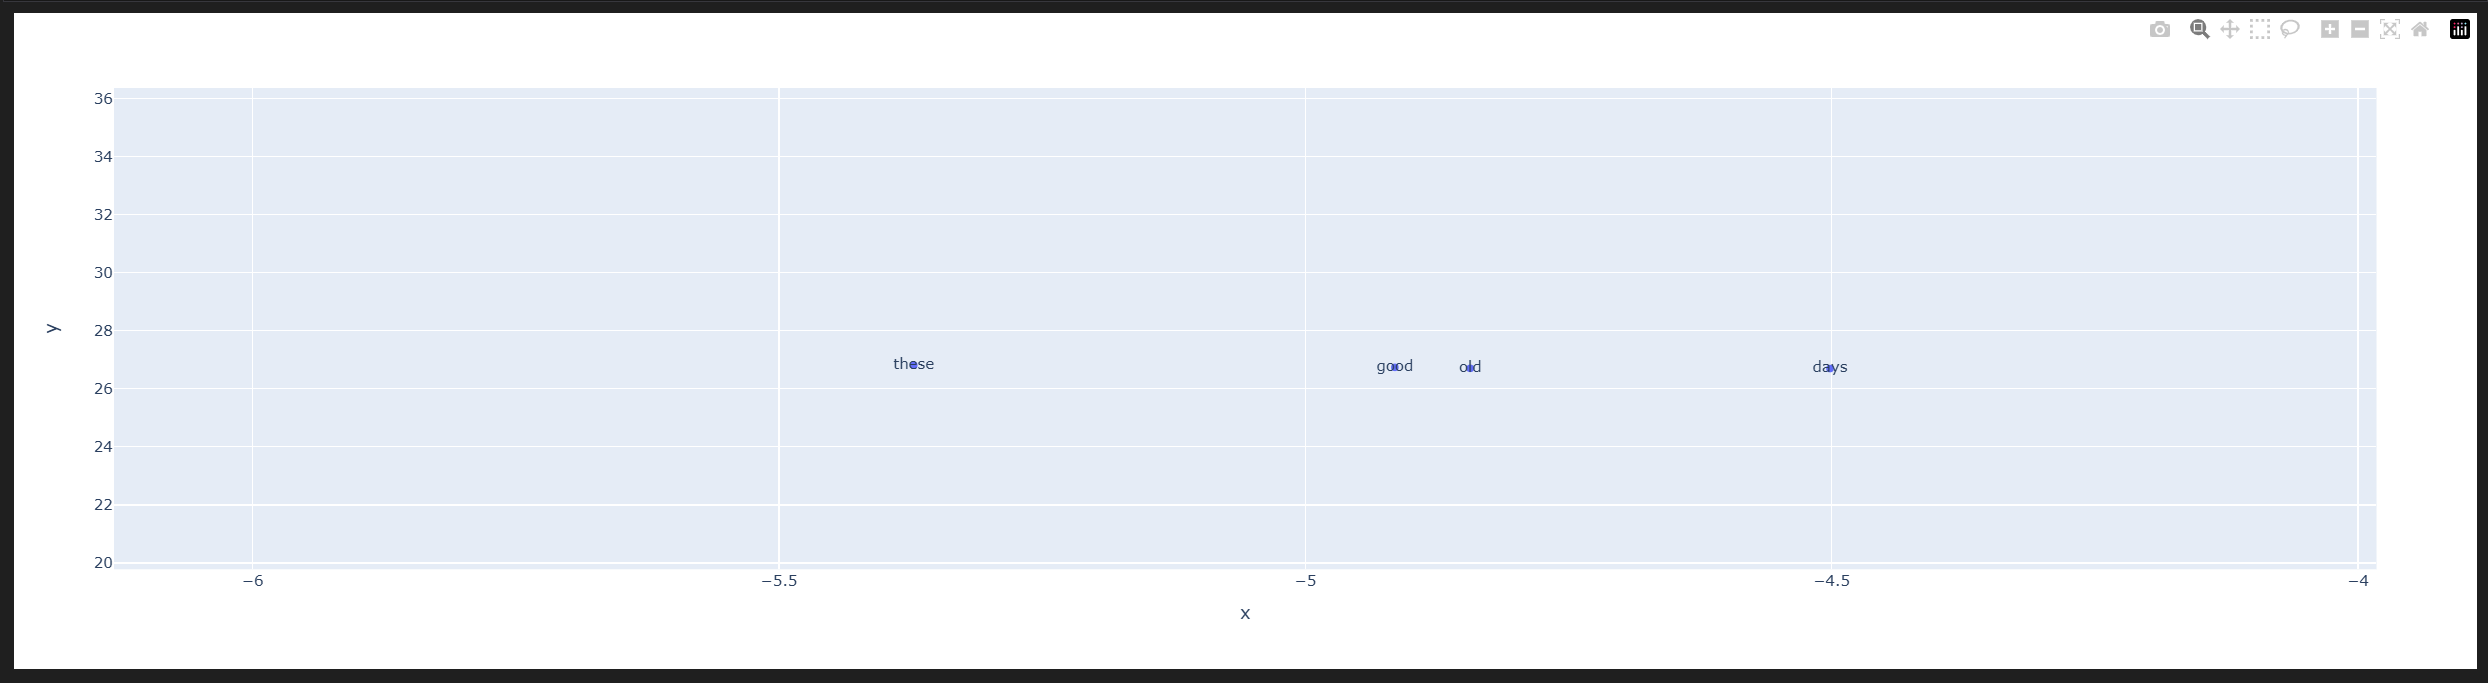

En este caso se observa la asociación de “good” con “old” y “days”, lo que refleja la relación semántica entre esas palabras para la conformación de una frase.

---

**oblivion, edge y weekend**

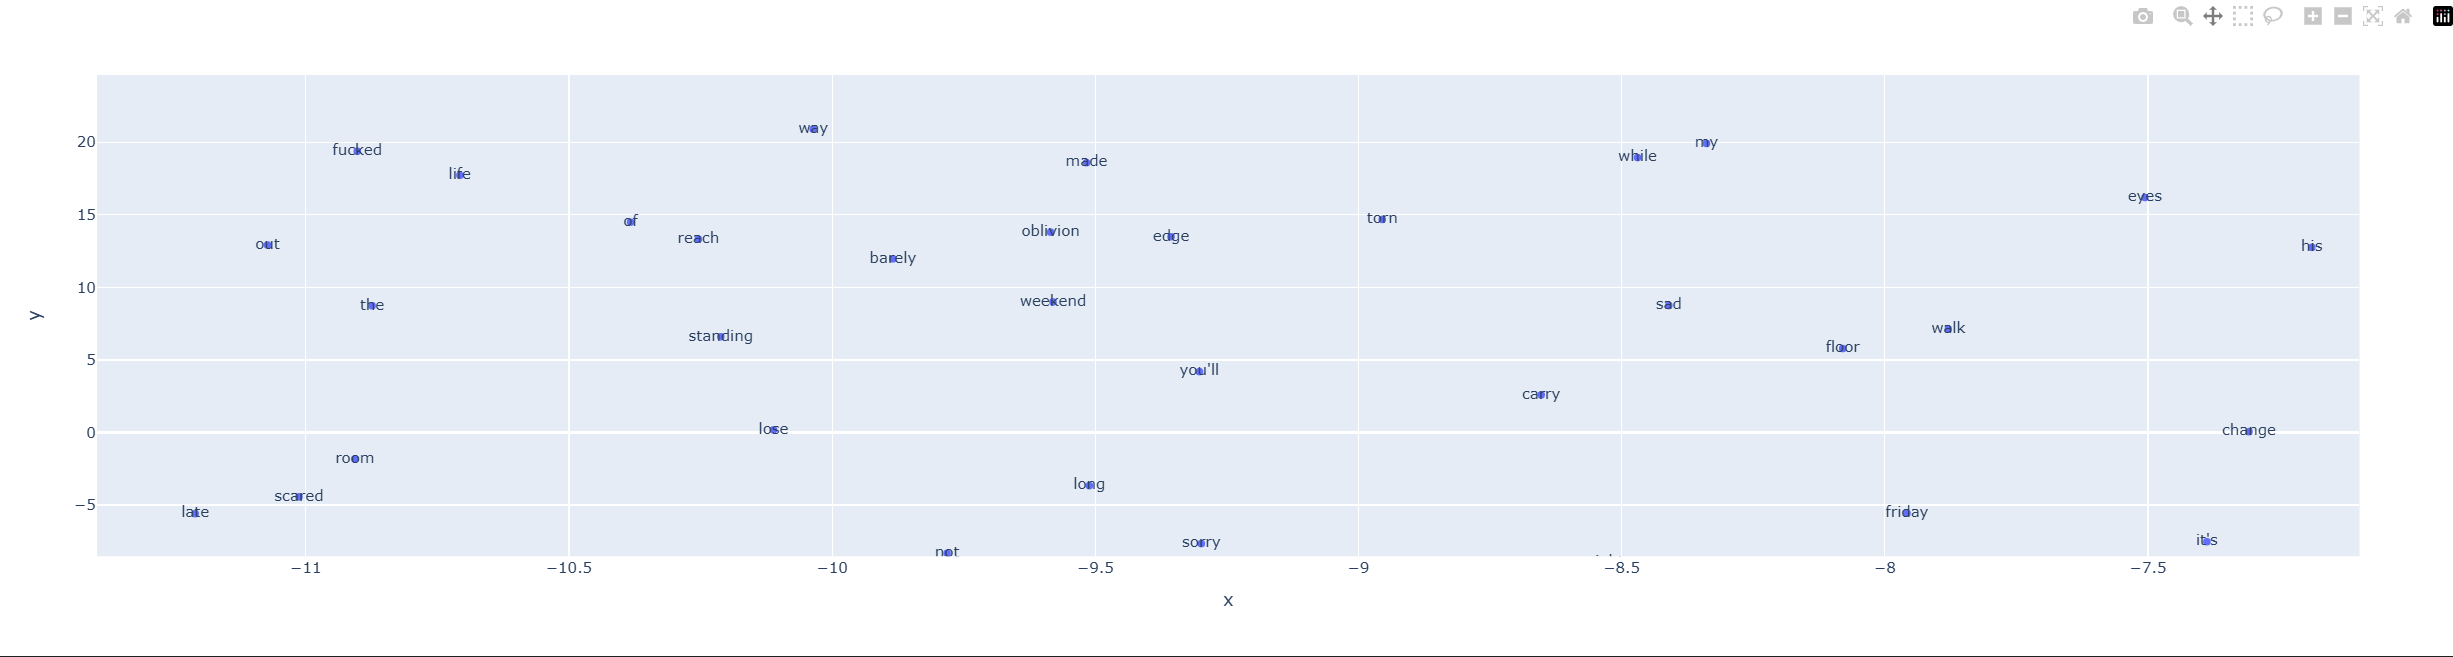

En este grupo las palabras “oblivion”, “edge” y “weekend” reflejan una temática con connotaciones sentimentales y de relaciones sociales, comunes en las letras de punk.

---

**late, scared, room**

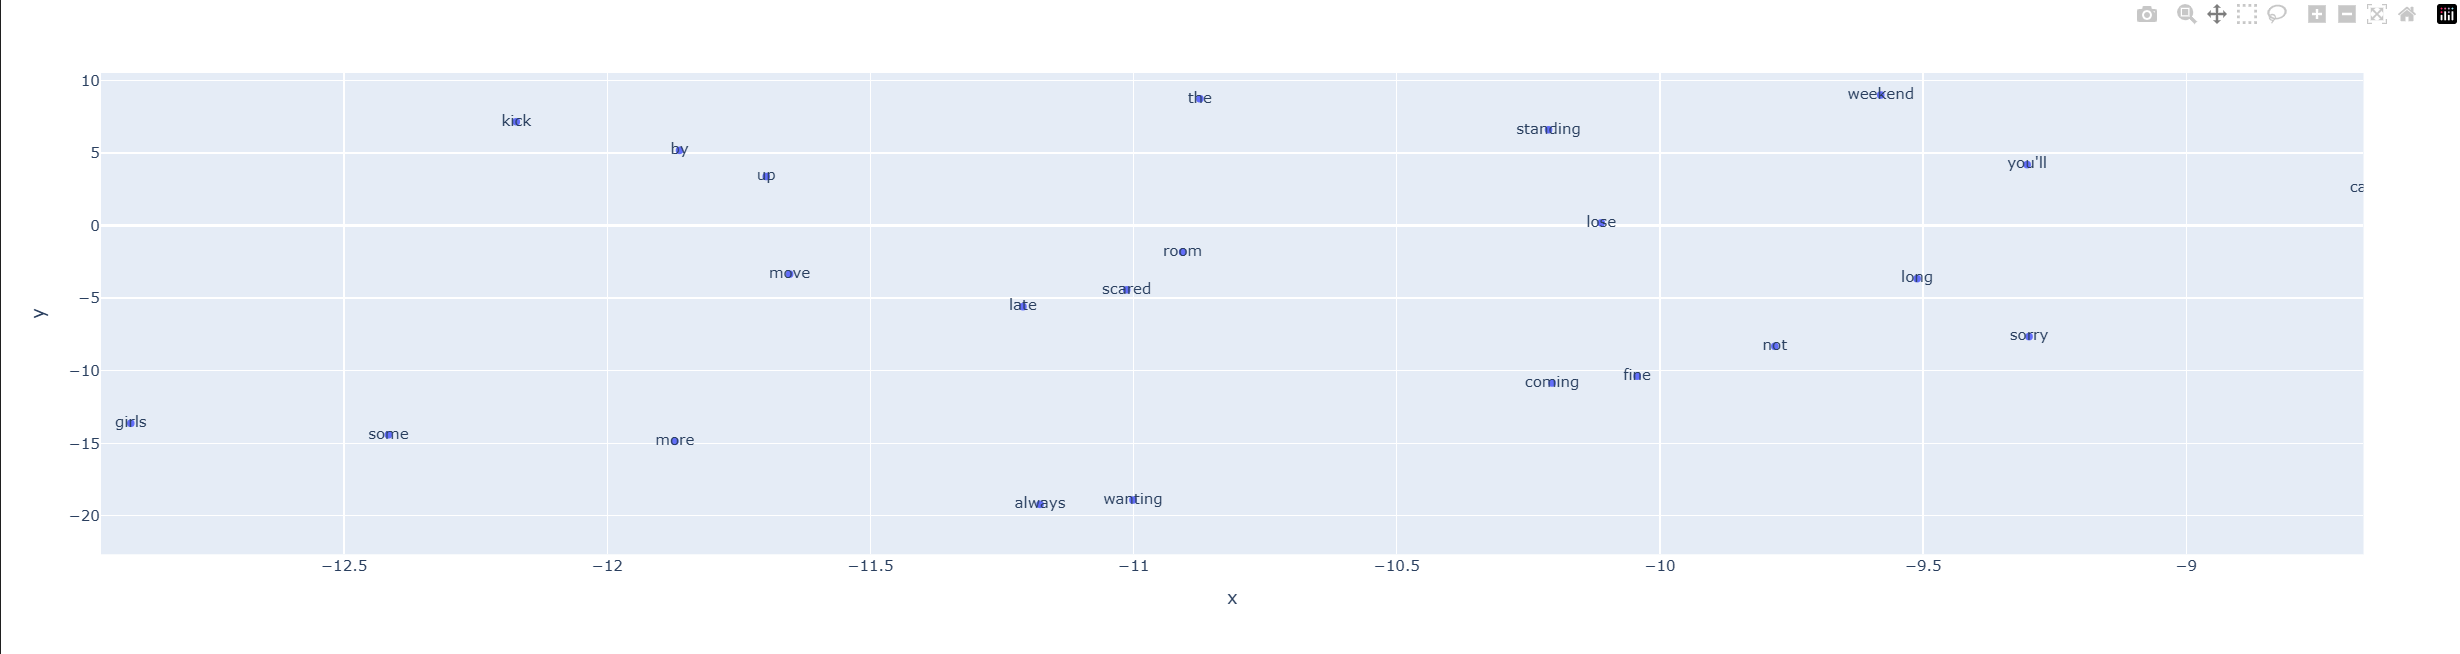

En este grupo las palabras hacen referencia a contextos de situaciones de depresión o tristeza.

---

**smile, summer, hand**

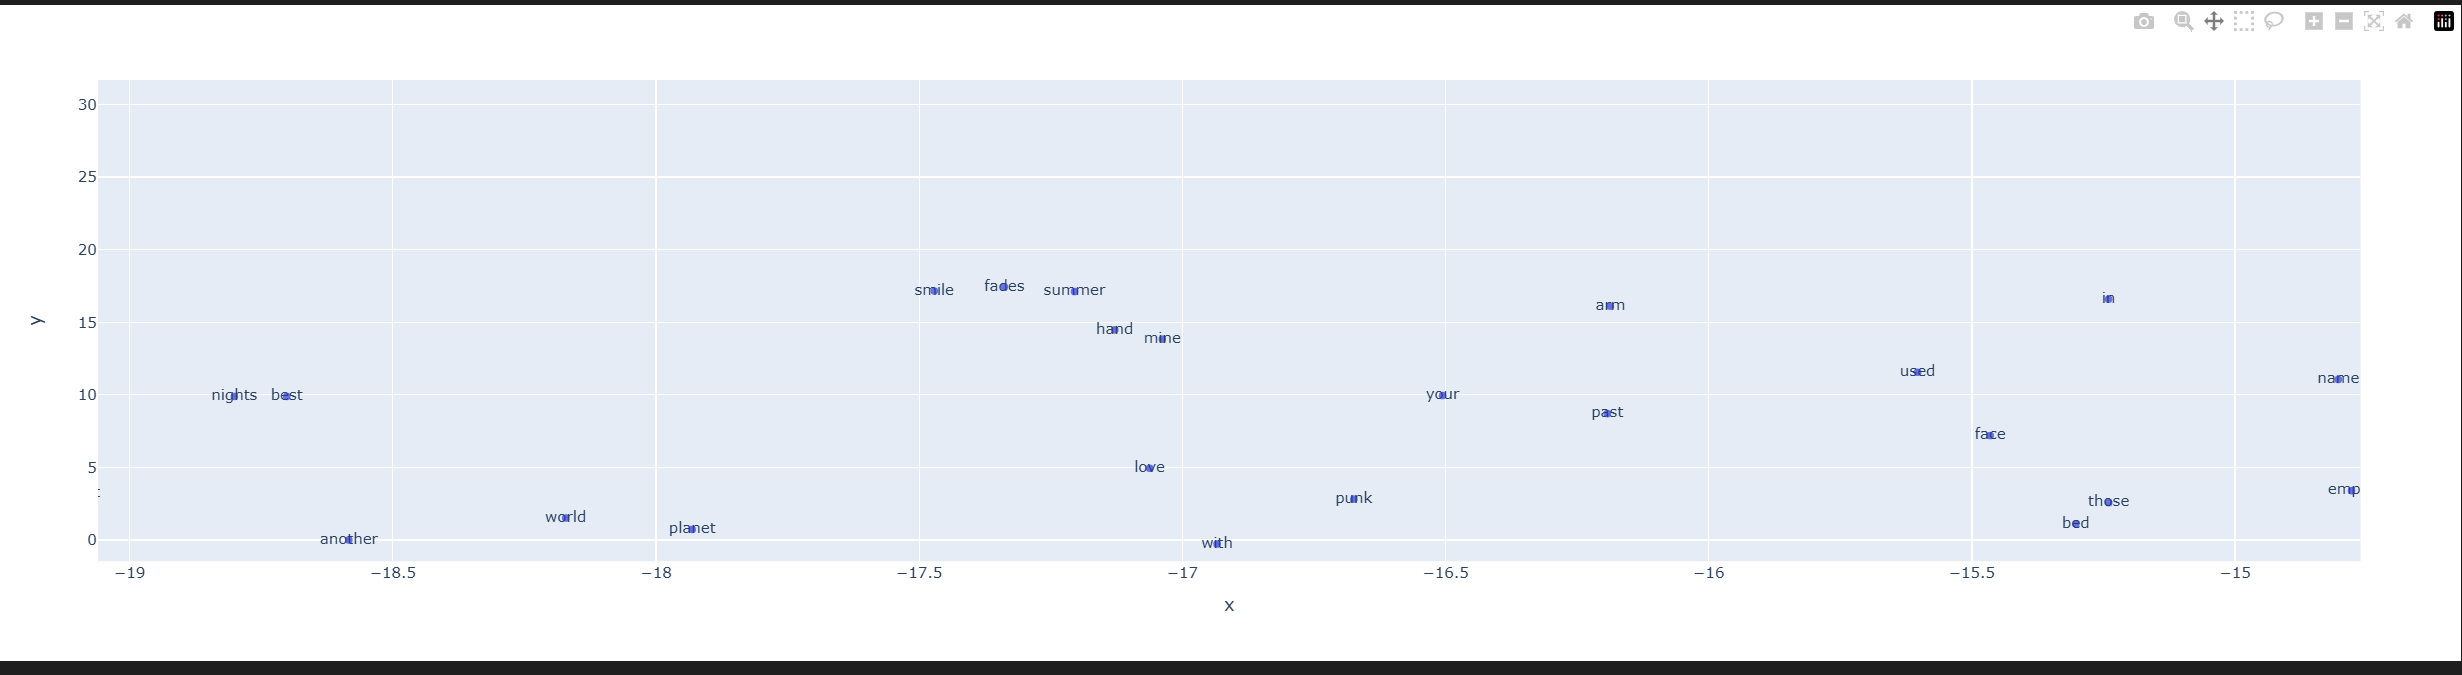

En este caso las palabras hacen referencia a la contextos mas positivos relacionados a felicidad, amor y contextos mas adolescentes



